<a href="https://colab.research.google.com/github/rajeevraizada/fMRI_tutorial_Jupyter_notebooks/blob/master/hrf_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial on the basics of convolving with a haemodynamic response function (HRF), using Python.

Written by Rajeev Raizada: rajeev dot raizada at gmail dot com
 
There are also two follow-up tutorials:

The math of convolution: [math_of_convolution.ipynb](https://colab.research.google.com/drive/1rAQcdTGImpdXjeI46Usd6Y1-hKoeUvEB#sandboxMode=true)

and the structure of an fMRI-analysis design
matrix: [design_matrix_tutorial.ipynb](https://colab.research.google.com/drive/1JxT6UsrLRbKsY-QG-1w--lUUE3UD26PK#sandboxMode=true)

None of these tutorials assume any prior knowledge of linear algebra.

This is a live Jupyter notebook, running on the Google Colab server (for free!). So, you can run the code, make changes to it, and see what happens. You need have a Google login (e.g. a Gmail account) in order to run the code on Google Colab. Before you run the code, Google will show a warning, telling you to check the code below, in order to make sure that it isn't trying to do anything malicious. Don't worry, it isn't! However, it's good practice to check, so please do take a look at the code below, before running it.

If you want to download the notebook, in order to run it on your own computer, then you can get it here: [hrf_tutorial.ipynb](http://www.bcs.rochester.edu/people/raizada/Python/hrf_tutorial.ipynb) 

#### Suggested exercise: change the code, re-run it, and see what happens

A good exercise is to change the onset times of the stimuli, and see what that does to the predicted voxel responses and how they combine with each other.

You can run each code cell by clicking on the [ ] part to its left. When you mouse-over this, it will turn into an arrow, meaning "Run". Click on that arrow to run that cell. 

You can also run each cell in this, or any other, Jupyter notebook by clicking inside it and hitting the "Shift"+"Enter" keys together.

The easiest way to run all the cells in one go is to click on the "Runtime" menu at the top of this page, and hit "Run all".

## The key points

1. The brain produces a fairly fixed, stereotyped blood flow response every time a stimulus hits it. That's the HRF (haemodynamic response function).

2. Once one of these resonses starts, it just does its thing until it has finished. i.e. it peaks, it goes back down to zero, it undershoots  a bit, then it settles back to baseline. All this was kicked off as a a result of the stimulus coming in, and it will run to completion regardless of what stimuli, if any, come in later. (This is just an approximation of what really happens in the brain, of  course, but it turns out that it isn't all that far from being
true).

3. What we just described is exactly what the process called "convolution" is. To convolve, you need two things. First, you need an "impulse  response function" (IRF), i.e. the chain of events that will be started  off every time an "impulse" happens, e.g. the brain sees a stimulus. And in the brain, the response to each impulse is the haemodynamic response function --- the HRF. Every time a stimulus comes in, one of these HRFs gets started off, and then it runs it course (peak,  undershoot, baseline) over the next 16 seconds or so.

Second, you need a vector to be convolved with that impulse response function. A vector is just a bunch of numbers in a row. In this case, our vector to be convolved is a list of whether a stimulus is shown or not, at each moment in time. So, we have a bunch of numbers lined up in a row, with time being represented by our position  along the row.  This type of vector is often referred to as a time-series.

In this case, the time-series is describing whether a stimulus is being shown at that moment in time or not. If there's no stimulus, we put a zero. If there is a stimulus, we put a 1. The first number is what is happening at time t=0,  the second number is what is happening at t=1 etc.

Here's a key point: every stimulus will kick off its own HRF, and so it can often happen that the previous stimulus's HRF hasn't finished by the time the next stimulus, with its new HRF comes in. So, the two HRFs will overlap in time.

In convolution, if you get different impulse response functions  overlapping in time, you can work out what the total response at that moment in time will be simply by adding up the individual  responses.

To say that you can get the total response just by adding up the individual overlapping responses is exactly what it means to say that the system is **linear**. If something is linear, then its  total response to separate inputs is just the sum of what its individual responses would have been to the individual inputs.

Does the brain do this? Does it just "add up" blood flow responses which are overlapping?

**Yes!** (to a reasonable approximation). And that is why convolution does a reasonable job of describing what the brain does.

To see more detail about the math of convolution, look at the companion program math_of_convolution.ipynb

4. In fMRI, the data that we get for each voxel is the blood oxygenation at that voxel at each point in time. We also know what the presentation times of our stimuli were. So, what any fMRI-analysis program does is this: It takes the time series of stimulus onsets, and convolves it with the HRF. This gives a **prediction** of the blood flow response that we should get a given voxel, if that voxel is responding to the stimuli.

Then, we take that prediction, and go and compare it against the measured data. And we see how well they match.

First let's create a made-up vector that looks like an HRF. A vector is just a bunch of numbers in a row. In Python, we make a vector by putting the row of numbers inside square brackets [  ]

Give one value for each 1-second time point. So, the 18 numbers in the vector below correspond to the values of the HRF from time=0 to time=18.

Note that the important thing about the HRF here is  just the overall **shape** that it has, not the exact values of the numbers. So, it doesn't mean anything that the max value in the numbers below is 9, or 9.2 or whatever. It's the shape of the HRF curve over time that matters.

(Actually, this isn't completely true.  For some math-related purposes it turns out that it's convenient to have the HRF sum to 1, and this is what SPM does.  But it would be a distraction to worry about that right now. Let's just define an HRF with the right overall shape, and plot it.)

First, we import the Python modules that we need.

In [0]:
import numpy as np
from matplotlib import pyplot as plt

# This next line just makes the fonts bigger. Their default size is too small
plt.rcParams.update({'font.size': 12})

Now let's create a vector that has the overall shape of a real HRF. We are going to make a NumPy array, which is just like a normal list, except that you can do math with it.

In [0]:
hrf = np.array([ 0, 0, 1, 5, 8, 9.2, 9, 7, 4, 2, 0, -1, -1, -0.8, -0.7, -0.5, -0.3, -0.1, 0, 0 ])

Let's plot it. For that, we need to make a vector of time-values to use as the x-coordinates 


In [0]:
time_vector = range(0,20)

Now we will plot the HRF against time, with time_vector as the x-coordinates, hrf as the
y-coordinates, and with the line style being a solid line with circles on it. The way to specify "solid line with circles on it" is to make the third argument be 'o-'


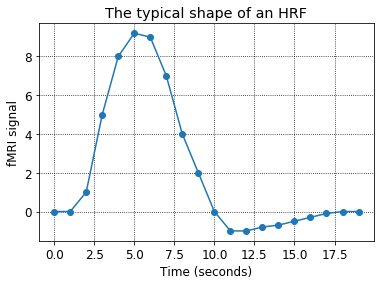

In [0]:
plt.plot(time_vector,hrf,'o-')  
                            
plt.xlabel('Time (seconds)')
plt.ylabel('fMRI signal')
plt.title('The typical shape of an HRF') 
plt.grid(color='k',linestyle=':')     # Overlay a dotted-line grid on top of the plot

Now let's make a vector of that is the time-series of our stimulus onsets, so that we can convolve that vector with the HRF, as described in the intro above.

A vector is just a bunch of numbers in a row. In this case, they are lined up in time. i.e. the first number is what is happening at time t=0, the second number is what is happening at t=1 etc. Our vector to be convolved is a list of whether a stimulus is shown or not, at each moment in time. If there's no stimulus, we put a zero. If there is a stimulus, we put a 1.

Suppose that our scan lasts 60 seconds, and that we use a visual stimulus: we flash a light at time t=10.

Let's make an stimulus-time-series vector that has one element for each second of time. Then the vector for that light stimulus will have a 1 in the 10th position, meaning t=10, and will be zeros everywhere else.

So, it's 9 zeros, then a 1, then 50 more zeros, making the vector have 60 entries altogether, for the 60 second scan.

Note that by just putting a single 1 to represent the flash of light, we are saying that the flash happened suddenly, just at that moment of time, i.e. it was an event, as opposed to a block (also called an "epoch"), in which the stimuli are spread out over a longer period of time. E.g. a stimulus-block might last twenty seconds, rather than an event, which happens at a single moment.

This sudden flash of light will spark off a sudden neural event, in this case a sudden burst of neural firing in visual cortex.

In Python, we can make n zeros in a row, like this: [0] * n

Note that Python starts counting at zero, not at one. (Matlab and Julia start counting at 1). So, to put a 1 at t=10, we actually need to put that 1 in the 11th position, so that it has 10 preceding zeros in the positions 0,1,2,...,9

To make the whole big vector with 10 zeros, a single 1, and then 50 zeros, we can just put the separate vectors next to each other in a row, and then concatenate them using the + sign, like this:

In [0]:
first_light_stim_time_series = [0]*10 + [1] + [0]*50

We are going to do math with this time-series and the others below (not much math, just adding and convolving), so we will convert from lists to NumPy arrays, by wrapping np.array() around them.

Notice that we used the + sign above to concatenate some lists. So, the + sign didn't actually add the elements of the lists, it just joined them all together. Below, we are going to do elementwise addition, so we'll want + to actually mean "perform addition". For that, we need to convert the lists into NumPy arrays.


In [0]:
first_light_stim_time_series = np.array([0]*10 + [1] + [0]*50)

Let's display this on the screen, using the print() function.

First we show the name of the variable, by putting single quotes around its name, to tell Python that it is a string. Then we start a new line by printing the special character '\n', which is the symbol for "newline". Then we print out the actual value of the variable, simply by passing it as the next input to print(). 

In [0]:
print('first_light_stim_time_series','\n',first_light_stim_time_series)

first_light_stim_time_series 
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Translation-guide

Here we have made a time-series whether for every time-point (t=0, t=1, etc.) we are explicitly saying whether or not a stimulus is being shown. In this case, the light is shown at t=10, so put a 1 as the 10th element, and for the rest of the time no lights are shown, so we put 0 everywhere else.

However, when using an fMRI-analysis package, people typically don't explicity make the whole time-series. They simply tell the package what the onset-times of the stimuli are, and let the package build the time-series of 0's and 1's on its own.

So, for the case where we have a single light stimulus at t=10, the info entered into the analysis package would be something like:

onset_times = [ 10 ]

Similarly, if we flashed one light at t=10 and another at t=30, then we'd enter: \
onset_times = [ 10, 30 ]

In this tutorial, and also in design_matrix_tutorial, we're going to explicitly make the stimulus-time-series vectors, rather than only supplying the onset-times, because these time-series vectors are the things that actually get convolved with the HRF. In an fMRI-analysis package, these time-series vectors would get made and convolved "behind the scenes", but we want to see everything in full view!

Now that we have the stimulus-time-series vector and the HRF vector, we can convolve them. In Python, the command to convolve two vectors is a part of the NumPy module, conveniently called "convolve". As is standardly done, we imported NumPy at the beginning of the script and gave it the abbreviated name "np", so the convolution command is np.convolve()

So, to convolve the time-series with the HRF, we do this:

In [0]:
hrf_convolved_with_stim_time_series = np.convolve(first_light_stim_time_series,hrf)

Let's print that output as text:

In [0]:
print('hrf_convolved_with_stim_time_series','\n',hrf_convolved_with_stim_time_series)

hrf_convolved_with_stim_time_series 
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   5.
  8.   9.2  9.   7.   4.   2.   0.  -1.  -1.  -0.8 -0.7 -0.5 -0.3 -0.1
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]


Now let's plot it, using the Matplotlib PyPlot module, which we imported using the abbreviation "plt":

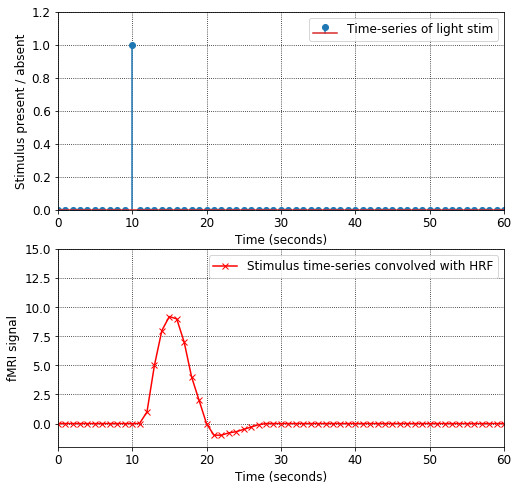

In [0]:
plt.figure(figsize=(8, 8))   # This makes the figure bigger: 8x8

plt.subplot(2,1,1) # This is just to make the plots line up prettily 
                   # The first number is how many rows of subplots we have: 2 
                   # The second number is how many columns: 1 
                   # The third number is which subplot to draw in: the first one
                   # So, we end up with two plots stacked on top of each other,
                   # and we draw in the first one (which is the upper subplot)

# Show when the stimulus is presented. We're using the
# command "stem" to plot here, instead of the more standard command "plot". 
# "Stem" makes a nice looking plot with lines and circles. 
# This type of plot is good for showing discrete events, 
# such as stimulus onsets.
plt.stem(first_light_stim_time_series,label='Time-series of light stim') 
                    # The label-string will show up in the figure legend

plt.grid(color='k',linestyle=':') # Overlay a black dotted-line grid on top of the plot
                    # The letter 'k' is used for black, because 'b' is blue!

plt.legend()        # Make a legend to say what the plot-lines are showing

plt.axis([0, 60, 0, 1.2]) # This just sets the display graph axis size 
                          # The first two numbers are the x-axis range: 0 to 60
                          # The last two numbers are the y-axis range: 0 to 1.2 
      
plt.xlabel('Time (seconds)')
plt.ylabel('Stimulus present / absent');

plt.subplot(2,1,2)        # Draw in the second subplot (the lower one)

# With my super-long (but thereby clear, hopefully !) variable names,
# this next command is a bit long. So, we'll split it across two lines
# by using the \ symbol, which tells Python that the command continues
# across a line break. Without that \, a line break starts a new command.
plt.plot(hrf_convolved_with_stim_time_series,'rx-', \
         label='Stimulus time-series convolved with HRF')
        # The argument 'rx-' means: Draw in red (r), 
        # use cross-shaped markers (x), 
        # and join them with a solid line (-) grid on
      
plt.legend() 
plt.axis([0, 60, -2, 15])
plt.xlabel('Time (seconds)')
plt.ylabel('fMRI signal')
plt.grid(color='k',linestyle=':')

You might be wondering why we didn't specify an x-coordinate vector in the two plot commands just now.

e.g. plt.plot(hrf_convolved_with_stim_time_series,'rx-')

We gave the y-coord values: the vector "hrf_convolved_with_stim_time_series" But we didn't give any x-coord values. When the plot command is given just one vector, it automatically plots the first value at x=0, the second at x=0 etc. Because the time-axis that we want in these plots starts at 0 and goes up in steps of 1, this default is fine for us here.

Next, we will make a different time-series, now with a light stimulus in our time-series being presented at t=30.

We'll make a new stimulus-time-series vector for it, just like we did above. Except now there are 30 zeros, then a 1, then 30 zeros

In [0]:
second_light_stim_time_series = np.array([0]*30 + [1] + [0]*30)

Because the two vectors first_light_stim_time_series and second_light_stim_time_series are the same length (they are both 61 elements long, for the 60 second scan, with an extra element for t=0 because Python starts counting from zero), we can add them together, element-by-element.

This will make a new vector that has a 1 at t=10, a 1 at t=3-, and zeros everywhere else.

In [0]:
all_lights_time_series = first_light_stim_time_series + second_light_stim_time_series

print('all_lights_time_series','\n',all_lights_time_series)

all_lights_time_series 
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Now we can do the convolution, using the NumPy command "convolve"

In [0]:
hrf_convolved_with_all_lights_time_series = np.convolve(all_lights_time_series,hrf)

Let's plot the result of this convolution:

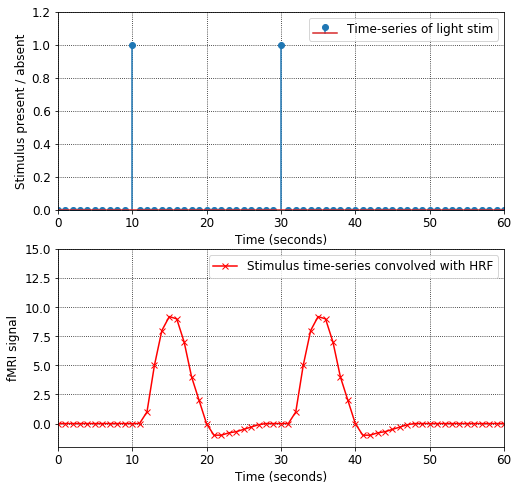

In [0]:
plt.figure(figsize=(8, 8))   # This makes the figure bigger: 8x8

plt.subplot(2,1,1)  # This is just to make the plots line up prettily 
plt.stem(all_lights_time_series,label='Time-series of light stim') 
plt.legend() 
plt.axis([0, 60, 0, 1.2])
plt.xlabel('Time (seconds)')
plt.ylabel('Stimulus present / absent')
plt.grid(color='k',linestyle=':')

plt.subplot(2,1,2)
plt.plot(hrf_convolved_with_all_lights_time_series,'rx-', \
         label='Stimulus time-series convolved with HRF') 

plt.legend() 
plt.axis([0, 60, -2, 15])
plt.xlabel('Time (seconds)')
plt.ylabel('fMRI signal')
plt.grid(color='k',linestyle=':')

Now let's try moving the two stimulus onsets closer together. This will show how the two HRFs add together to make the measured signal.

Let's make the second flash happen at t=16, and add it to the time-series for the first flash.

In [0]:
second_light_stim_time_series = np.array([0]*16 + [1] + [0]*44)

# When we add the two light-stim time series together,
# we now have two onsets: at t=10 and t=16.
all_lights_time_series = first_light_stim_time_series + \
                         second_light_stim_time_series

print('all_lights_time_series','\n',all_lights_time_series)

all_lights_time_series 
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Let's convolve each of these time-series with the HRF.

In [0]:
hrf_convolved_with_all_lights_time_series = np.convolve(all_lights_time_series,hrf)

hrf_from_first_light = np.convolve(first_light_stim_time_series,hrf)

hrf_from_second_light = np.convolve(second_light_stim_time_series,hrf)

And now let's plot all of them, stacked on top of each other using subplots, so that we can see how they align in time.

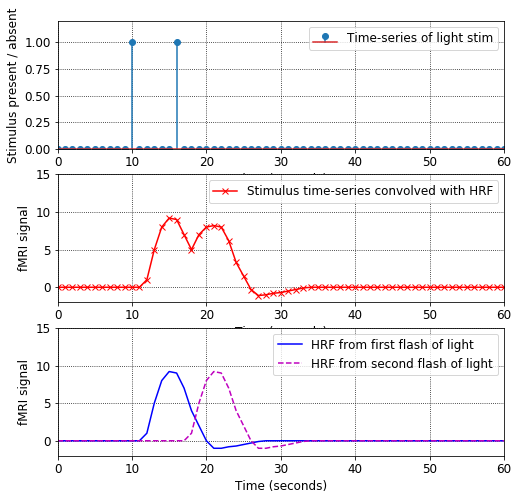

In [0]:
plt.figure(figsize=(8, 8))   # This makes the figure bigger: 8x8

plt.subplot(3,1,1)  # This is just to make the plots line up prettily 
plt.stem(all_lights_time_series,label='Time-series of light stim') 
plt.legend() 
plt.axis([0, 60, 0, 1.2])
plt.xlabel('Time (seconds)')
plt.ylabel('Stimulus present / absent')
plt.grid(color='k',linestyle=':')

plt.subplot(3,1,2)
plt.plot(hrf_convolved_with_all_lights_time_series,'rx-', \
         label='Stimulus time-series convolved with HRF') 

plt.legend() 
plt.axis([0, 60, -2, 15])
plt.xlabel('Time (seconds)')
plt.ylabel('fMRI signal')
plt.grid(color='k',linestyle=':')

plt.subplot(3,1,3)
plt.plot(hrf_from_first_light,'b-',label='HRF from first flash of light')
plt.plot(hrf_from_second_light,'m--',label='HRF from second flash of light')

plt.legend() 
plt.axis([0, 60, -2, 15])
plt.xlabel('Time (seconds)')
plt.ylabel('fMRI signal')
plt.grid(color='k',linestyle=':')

Now let's put in a third onset, so we have onsets at t=10, t=13 and t=16. Having all these trials following each other in a row is starting to look like a blocked design. When we plot the HRF that these closely-spaced trials evoke, below, notice how the individual HRFs from each trial all start to lump together into one big HRF. That's what the HRFs look like in a blocked design.

In [0]:
# A flash of light, with onset-time t=13
third_light_stim_time_series = np.array([0]*13 + [1] + [0]*47)

Now let's combine all three stimuli together, convolve that new stimulus time course with the HRF, and plot the results.

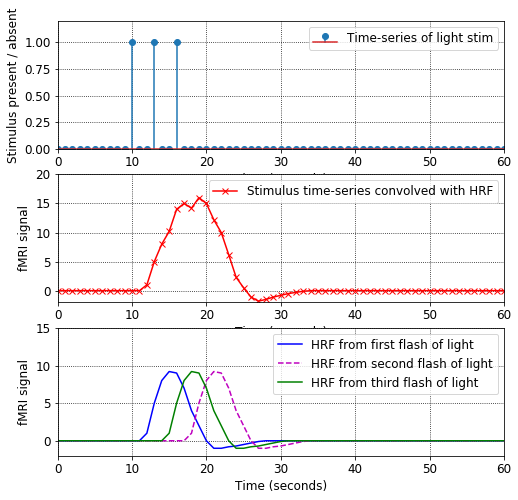

In [0]:
all_lights_time_series = first_light_stim_time_series + \
                         second_light_stim_time_series + \
                         third_light_stim_time_series

hrf_convolved_with_all_lights_time_series = np.convolve(all_lights_time_series,hrf)

hrf_from_first_light = np.convolve(first_light_stim_time_series,hrf)
hrf_from_second_light = np.convolve(second_light_stim_time_series,hrf)
hrf_from_third_light = np.convolve(third_light_stim_time_series,hrf)


plt.figure(figsize=(8, 8))   # This makes the figure bigger: 8x8

plt.subplot(3,1,1)  # This is just to make the plots line up prettily 
plt.stem(all_lights_time_series,label='Time-series of light stim') 
plt.legend() 
plt.axis([0, 60, 0, 1.2])
plt.xlabel('Time (seconds)')
plt.ylabel('Stimulus present / absent')
plt.grid(color='k',linestyle=':')

plt.subplot(3,1,2)
plt.plot(hrf_convolved_with_all_lights_time_series,'rx-', \
         label='Stimulus time-series convolved with HRF') 

plt.legend() 
plt.axis([0, 60, -2, 20])
plt.xlabel('Time (seconds)')
plt.ylabel('fMRI signal')
plt.grid(color='k',linestyle=':')

plt.subplot(3,1,3)
plt.plot(hrf_from_first_light,'b-',label='HRF from first flash of light')
plt.plot(hrf_from_second_light,'m--',label='HRF from second flash of light')
plt.plot(hrf_from_third_light,'g-',label='HRF from third flash of light')

plt.legend() 
plt.axis([0, 60, -2, 15])
plt.xlabel('Time (seconds)')
plt.ylabel('fMRI signal')
plt.grid(color='k',linestyle=':')